# **India Inflation Forecast Model**





# **Sections**

## **Section 1: Introduction**
## **Section 2: Data Preparation and Visualization**
## **Section 3: Seasonality Tests**
### **Section 3.1. Data Preparation**
### **Section 3.2. Preliminary Seasonality Tests Using STL and ACF**
### **Section 3.3. Final Seasonality Test - CH Test**
## **Section 4: 10-year Forecast**
### **Section 4.1. 10-year Forecast: Pre-COVID Regime**
### **Section 4.2. 10-year Forecast: Post-COVID Regime**




---------------------------------------------------------------------------------------------------------------




## **Section 1: Introduction**
This notebook develops a monthly time-series forecasting model for consumer inflation in India over a 10-year horizon. The analysis uses the official All-India Consumer Price Index (CPI – Combined) year-on-year (YoY) inflation series published by the Ministry of Statistics & Programme Implementation (MoSPI), Government of India. MoSPI’s CPI (Base Year 2012 = 100) is the standard measure of retail price inflation and is released monthly through the National Statistical Office (NSO) press-release annexures.

The dataset employed here spans January 2014 through August 2025 and provides the monthly percentage change in the General CPI over the corresponding month of the previous year. Two calendar years—2020 and 2021—have been deliberately excluded from the modelling data set. These years coincide with the peak of the COVID-19 pandemic, when India experienced:

1. Unprecedented supply-chain disruptions and demand shocks,
2. Nation-wide lockdowns and abrupt changes in consumption patterns, and
3. Gaps in official data collection, with MoSPI itself noting that CPI for April–May 2020 could not be compiled.

These events constitute a structural break that would bias the estimation of long-run seasonal and trend dynamics if left unadjusted. By excluding these observations, the forecasting model aims to capture the underlying “normal-regime” inflation behaviour of the Indian economy, producing a baseline projection that reflects typical macroeconomic and seasonal drivers rather than the one-off pandemic shock.

Subsequent sections of this notebook outline the data-preparation steps, stationarity diagnostics, and the implementation of classical time-series models—specifically ARIMA/SARIMA variants—to generate monthly forecasts of India’s headline inflation for the next 120 months (10 years).

**DISCLAIMER:** This document summarizes an exploratory ARIMA exercise on YoY CPI inflation. Unit-root testing here is limited to seasonality and does not cover level/trend stationarity; extended residual diagnostics and rolling backtests are planned for a follow-up. Please interpret long-horizon intervals as indicative rather than definitive.

In [1165]:
# Importing necessary packages for the model
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
import matplotlib.dates as mdates
from pmdarima.arima import CHTest
import warnings
warnings.simplefilter("ignore", category=FutureWarning)
from statsmodels.tsa.arima.model import ARIMA

## **Section 2: Data Preparation and Visualization**
This section shows a visual representation of the inflation data - as sourced from MoSPI.

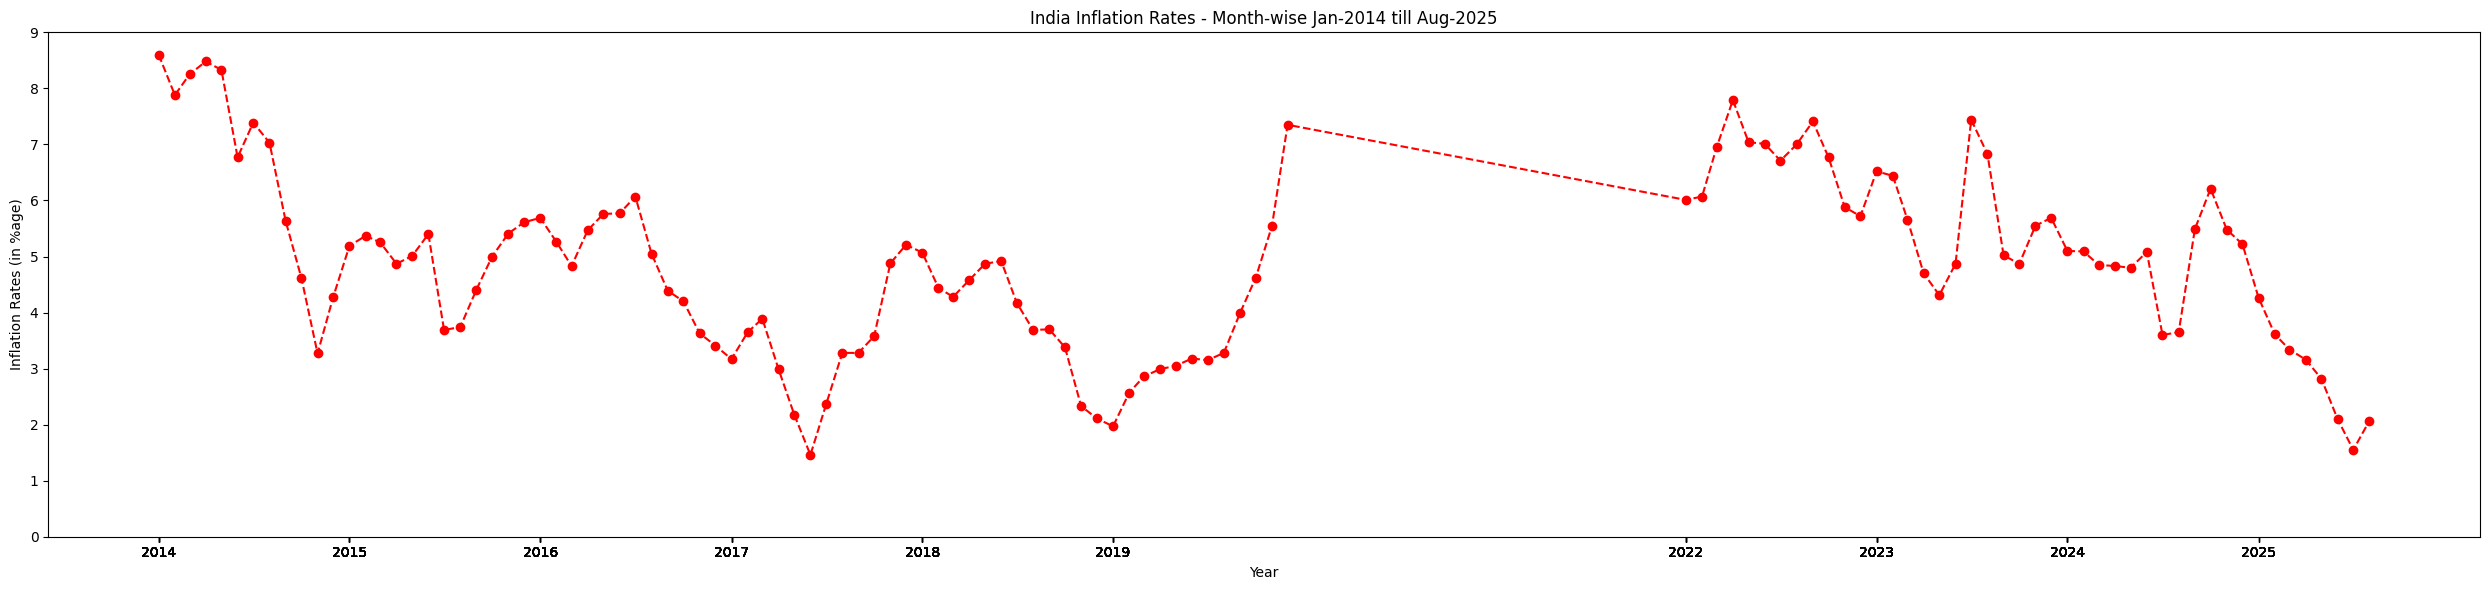

In [1166]:
# Initialize environment and set conditions
load_dotenv()
inflation_dataset = os.getenv('inflation_dataset')
forecast_pre_dataset = os.getenv('forecast_pre_dataset')
forecast_post_dataset = os.getenv('forecast_post_dataset')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Load data
df_inflation = pd.read_csv(inflation_dataset)
X_values = [dt.strptime(d, '%m/%d/%Y') for d in df_inflation['Date']]
Y_values = df_inflation['CPI_Inflation_YoY_Percent'].to_list()
Y_ticks = [round(i) for i in range(int(max(Y_values)+2))]
X_ticks = [dt.strftime(d, '%Y') for d in X_values]

# Visualize data
fig, ax = plt.subplots(figsize=(25, 6), dpi=100)
ax.plot(X_values, Y_values, '--', color='red', marker='o')
ax.set_title('India Inflation Rates - Month-wise Jan-2014 till Aug-2025')
ax.set_xlabel('Year')
ax.set_ylabel('Inflation Rates (in %age)')
ax.set_xticks(X_ticks)
ax.set_yticks(Y_ticks)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

# Generate dataset for next stage
df_seasonality_test_data = pd.DataFrame()
df_seasonality_test_data['Period'] = X_values
df_seasonality_test_data['Inflation_rates'] = Y_values


## **Section 3: Seasonality Tests**
This section uses decomposition and autocorrelation diagnostics to determine if the series has a recurring seasonal pattern and whether seasonal differencing is required before modeling.

Typical workflow for seasonality tests to gauge presence/ strength of seasonality is as follows:
1. **Conduct STL (Seasonal Trend Decomposition with LOESS), and determine Hyndman score**, for initial view of seasonality strength on the dataset. While this statistic gives an explanation on how much of the variance is explained by the seasonal component, it does not prescribe model differencing.
2. **Perform ACF (Autocorrelation Function) analysis** with a sensible maximum lag (e.g. 48 for monthly data). By performing a visual inspection of the output, we can identify significant spikes at multiples of the seasonal period (e.g., 12, 24, etc.). ACF at lag ($k$) is the Pearson Correlation between $X_t$ and $X_{t-k}$ **across all $t$**. Regular spikes at multiples of seasonal period ($s$) indicate seasonal dependence.
3. **Perform CH (Canova-Hansen) test** to conclusively determine the need and value of seasonal differencing.

Since our dataset is devoid of the 2020-21FY data, we have split the raw dataset into two regimes:
1. Regime 1: Pre-COVID dataset - for performing seasonality tests on the pre-COVID regime. Here, we have considered **lag=48 (4 years)** since we have data from Jan-2014 till Dec-2019.
2. Regime 2: Post-COVID dataset - for performing seasonality tests on the post-COVID regime. Here, we have considered **lag=24 (2 years)** since we have data from Jan-2022 till Aug-2025.

Seasonality tests will be performed on each dataset separately and final conclusions on scenario development shall be determined based on these conclusions.

### **3.1. Data Preparation:**
This section focuses on preparing the necessary datasets for running seasonal decomposition analysis and seasonality strength tests.

In [1167]:
# Data preparation adjusting for pre and post-COVID missing data
# Generating pre-COVID data for seasonality tests
df_seasonality_test_data_pre = df_seasonality_test_data[
    df_seasonality_test_data['Period']<'2020-01-01'
    ]
# Generating post-COVID data for seasonality tests
df_seasonality_test_data_post = df_seasonality_test_data[
    df_seasonality_test_data['Period']>'2021-12-01'
    ]
df_seasonality_test_data_pre.set_index('Period', inplace=True)
df_seasonality_test_data_post.set_index('Period', inplace=True)
df_seasonality_test_data_pre = df_seasonality_test_data_pre.asfreq('MS')
df_seasonality_test_data_post = df_seasonality_test_data_post.asfreq('MS')

### **3.2. Preliminary Seasonality Tests Using STL and ACF**
This section performs seasonal decomposition and seasonality strength tests on the pre-COVID and post-COVID datasets. STL (with the additive model) and the subsequent Hyndman score (along with ACF) have been used to establish the rpesence of seasonality in the two regimes and measure its strength in each.

#### **About STL:**
#### STL: Seasonal–Trend decomposition using Loess
**STL** stands for **Seasonal–Trend decomposition using Loess** (a.k.a. LOWESS: *LOcally WEighted Scatterplot Smoothing*). **LOESS** is a non-parametric smoothing technique that fits many small local regressions around each data point to generate a smooth curve without assuming a global formula and hence, in the context of this analysis, is a better alternative to exponential smoothing or weighted moving average, due to its ability to offer more flexible trend extraction.

**Model Explanations (selected model: additive)**
For an additive decomposition:
$$
y_t = T_t + S_t + R_t,
$$
where $$T_t = trend, S_t = seasonal component, R_t = remainder (noise).$$

For multiplicative behavior, use a log transform and decompose additively:
$$
\log y_t = T_t + S_t + R_t \quad \iff \quad y_t = e^{T_t}\cdot e^{S_t}\cdot e^{R_t}.
$$

**How STL works**

In simple terms, STL splits the raw dataset into 3 components:
1. **Trend** - this component outlines ONLY the underlying trend demonstrated by the raw data (sans the impact of seasonality and residuals).
2. **Seasonal** - this component outlines ONLY the seasonality that is baked into the raw data (sans the trend and residuals).
3. **Residuals** - this component outlines what is left in the raw data - after extracting the trend and seasonality from the same.

Below is a more detailed overview of STL:
1. **Seasonal extraction (cycle–subseries smoothing)**  
   For lag ($k$) (e.g., 12, 24, etc.), split the series into $k$ subseries by season (all Januaries, all Februaries, …) and smooth each subseries with LOESS to get a preliminary $\tilde{S}_t$.
2. **Low-pass filtering of seasonal**  
   Smooth $\tilde{S}_t$ again (moving averages + LOESS) so seasonality changes **slowly** over time.
3. **Trend extraction**  
   Detrend input via $y_t - S_t$, then smooth with LOESS to obtain $T_t$.
4. **Robust reweighting (optional but standard)**  
   Compute residuals $r_t = y_t - T_t - S_t$. Form robustness weights using a bisquare function on scaled residuals (MAD scale):
   $$
   u_t = \frac{r_t}{6\,\mathrm{MAD}(r)},\qquad
   b_t =
   \begin{cases}
   (1-u_t^2)^2,& |u_t|<1\\
   0,& \text{otherwise}
   \end{cases}
   $$
   Re-run seasonal & trend smoothing with weights multiplied by $b_t$ to **down-weight outliers**.
5. **Iterate**  
   STL alternates seasonal ↔ trend updates (inner loop) and robustness updates (outer loop) until changes are small.

**Pros vs. Cons**

**Pros**
- Works for **any seasonal period \(m\)** (not just 12/4).
- Allows **seasonality to evolve** over time.
- **Robust** to outliers (with `robust=True`).
- Transparent smoothness controls: `s.window` (seasonal), `t.window` (trend).

**Cons**
- Requires a **regular, gap-free** series (hence the raw data set has been split into pre and post-COVID data and separate STL tests have been performed on each).
- Window choices affect results (not a single “correct” setting).
- Descriptive method—no built-in forecasting (forecast components or the remainder with a model).

**Additive vs. multiplicative?**
- If seasonal amplitude is roughly **constant** - which is typically the case for inflation rates, use **additive**.
- If amplitude **scales with the level** - typically seen in revenue, sales data, decompose **log(y)** additively (equivalently multiplicative on \(y\)).

**Quantifying seasonal strength (Hyndman score)**
A handy indicator (0 = none, →1 = strong):
$$
\text{Strength} = \max\left(0,\; 1 - \frac{\mathrm{Var}(R)}{\mathrm{Var}(R+S)}\right).
$$
Higher values mean stronger seasonality.

#### **Seasonal Decomposition of pre-COVID regime:**

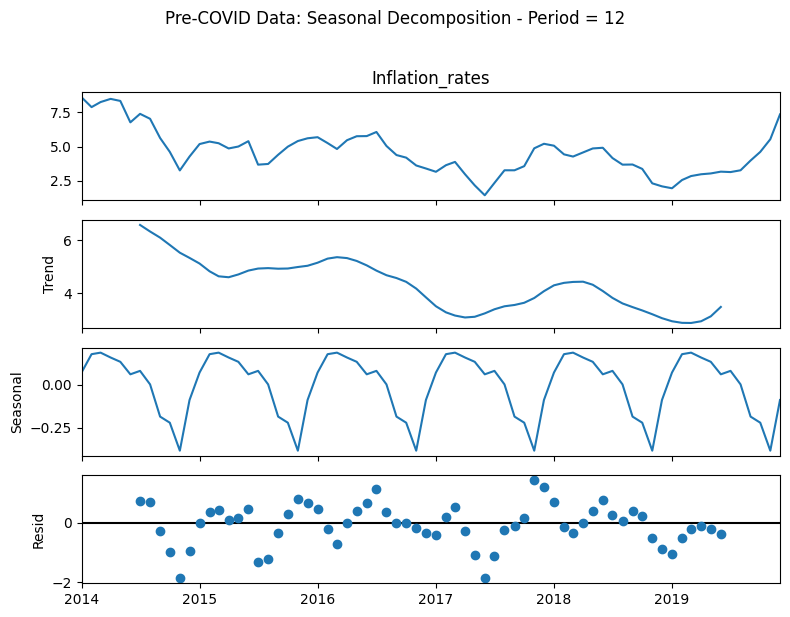

Pre-COVID data seasonality strength: 0.10
Pre-COVID data assessment based on Hyndman score:
Low seasonality strength


In [1168]:
# Seasonal decomposition for pre-COVID data (Aug-2014 till Dec-2019)
series_pre = df_seasonality_test_data_pre['Inflation_rates']
seasonal_decomp_pre = seasonal_decompose(series_pre, model='additive', 
                                         period=12)
fig_pre = seasonal_decomp_pre.plot()
fig_pre.set_size_inches(8, 6)
fig_pre.suptitle('Pre-COVID Data: Seasonal Decomposition - Period = 12', 
                 fontsize=12, y=1.02)
fig_pre.tight_layout()
plt.show()

# STL for seasonality strength
stl_pre = STL(series_pre, period=12, robust=True).fit()
T_pre, S_pre, R_pre = stl_pre.trend, stl_pre.seasonal, stl_pre.resid

# Hyndman seasonality strength score
strength_pre = max(0, (1 - (R_pre.var() / (R_pre.var() + S_pre.var() 
                                           + 2 * R_pre.cov(S_pre)))))
print(f'Pre-COVID data seasonality strength: {strength_pre:.2f}')
print('Pre-COVID data assessment based on Hyndman score:')
if strength_pre > 0 and strength_pre <= 0.3:
    print('Low seasonality strength')
else:
    print('High seasonality strength')

#### **Interpretation of STL analysis on pre-COVID regime:**
As evidenced from the STL decomposition, while the pre-COVID regime dataset does depict presence of seasonality, its strength is quite low (as evidenced based on the corresponding Hyndman Score). This means that while seasonal differencing can be factored into the dataset, based on interpretation of just the STL analysis, the same is not warranted. Additional ACF analysis and subsequent CH test results (as presented in the subsequent sections of this document) will provide better insights on the same.

#### **Seasonal Decomposition of post-COVID regime:**

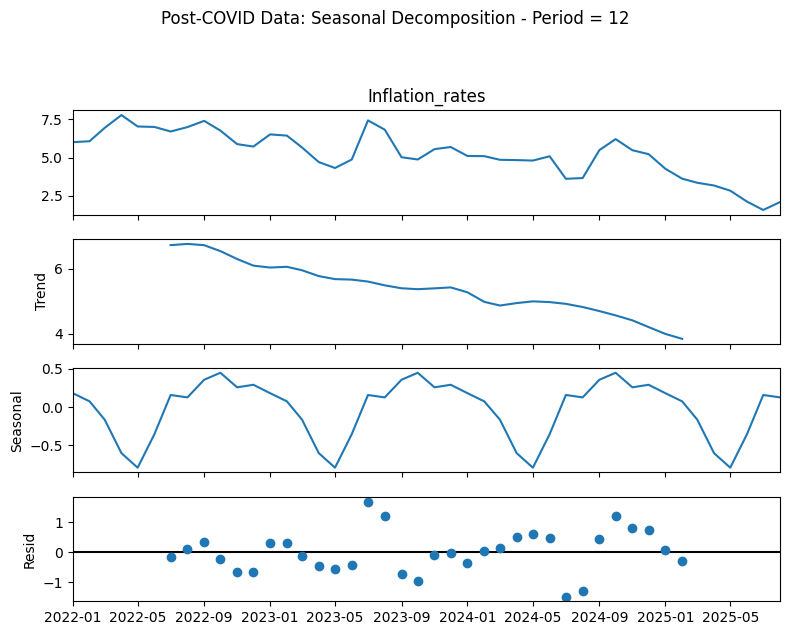

Post-COVID data seasonality strength: 0.32
Assessment based on Hyndman score:
High seasonality strength - select SARIMA.


In [1169]:
# Seasonal decomposition for post-COVID data (Jan-2022 till Aug-2025)
series_post = df_seasonality_test_data_post['Inflation_rates']
seasonal_decomp_post = seasonal_decompose(series_post, model='additive', 
                                          period=12)
fig_post = seasonal_decomp_post.plot()
fig_post.set_size_inches(8, 6)
fig_post.suptitle('Post-COVID Data: Seasonal Decomposition - Period = 12', 
                  fontsize=12, y=1.05)
fig_post.tight_layout()
plt.show()

# STL for seasonality strength
stl_post = STL(series_post, period=12, robust=True).fit()
R_post, S_post, T_post = stl_post.resid, stl_post.seasonal, stl_post.trend

# Hyndman seasonality strength score
strength_post = max(0, (1 - (R_post.var() / (R_post.var() + S_post.var() 
                                             + 2 * R_post.cov(S_post)))))
print(f'Post-COVID data seasonality strength: {strength_post:.2f}')
print('Assessment based on Hyndman score:')
if strength_post > 0 and strength_post <= 0.3:
    print('Low seasonality strength - select ARIMA.')
else:
    print('High seasonality strength - select SARIMA.')

#### **Interpretation of STL analysis on post-COVID regime:**
As evidenced from the STL decomposition, the post-COVID regime depicts a moderate presence of seasonality (as evidenced based on the corresponding Hyndman Score). This means seasonal differencing of the data is warranted. However, additional ACF analysis, and subsequent CH test results (as presented in the subsequent sections of this document), shall still be performed to conclusively establish the exact seasonal difference value.

#### **About ACF**
#### ACF: Autocorrelation Function
**ACF** measures linear correlation between a time series and **lagged** versions of itself. I.e., for lag $k$, it asks “how similar is $y_t$ to $y_{t-k}$?”

**How ACF works (high-level)**

In simple terms, ACF plots the correlation between the value of a series ($y_i$) at time $t$ and its value at time $t-k$ or $k$ periods earlier. The result (when applied across all data points in a series $Y$), gives us a graph that plots the correlations (vertical bars) between value of the series at time $t$ and value of the same series at time $t-k$ and the ±1.96/√n bands (shaded area). If this graph displays an oscillating pattern that shows significant spikes - repeating periodically (i.e. beyond the ±1.96/√n bands) - then we can conclude (with 95% confidence, if alpha = 5%) that seasonality is present in the raw data.

Below is a more detailed overview of ACF:

1. **Determine autocovariance**:
    For a weakly stationary series (i.e., a series of data whose mean $\mu$ and variance $\sigma^2$ do not change over time) $Y$, with mean $\mu$ and variance $\sigma^2$, determine the **autocovariance** at lag $k$, given as:

    $$
    \gamma(k) \;=\; \operatorname{Cov}(y_t,\; y_{t-k})
    \;=\; \mathbb{E}\!\big[(y_t-\mu)(y_{t-k}-\mu)\big].
    $$

    which measures the covariance between today’s value $y_t$ and the value $k$ time steps earlier ($y_{t-k}$).

2. **Determine autocorrelation**: 
    The **autocorrelation** at lag $k$ for the series $Y$ is then determined using:

    $$
    \rho(k) \;=\; \frac{\gamma(k)}{\gamma(0)} \;=\; \frac{\gamma(k)}{\sigma^2}.
    $$

    which normalizes the covariance (by the variance) so the result is a pure correlation coefficient (i.e., values lie between -1 and 1).

**ACF application in real data**:
Since, in the case of real data, we do not know the true mean or true expected values, we typically use the **sample ACF** method; given using the equation:

$$
\hat{\rho}(k)
\;=\;
\frac{\sum_{t=k+1}^{n}(y_t-\bar y)(y_{t-k}-\bar y)}
     {\sum_{t=1}^{n}(y_t-\bar y)^2},
$$

where $\bar y$ is the sample mean (which replaces the true mean) and $\sum$ is summation of the data (which replaces the expected values $\mathbb{E}$) 

**Interpretation of ACF:**
- **Seasonality:** Significant spikes at **seasonal lags** (e.g., $12, 24, 36,\dots$ for monthly data).
- **Trend / non-stationarity:** ACF that **decays slowly** (stays high for many lags) → likely non-stationary → difference first.
- If the ACF shows spikes at $12, 24, …$ → seasonal dynamics present (consider **SARIMA**).
- If ACF decays slowly → **difference (and possibly seasonal difference)**.

**Significance & confidence bands**
Under the null hypothesis of white noise (i.e., zero mean, constant variance, and no predictable pattern), approximate 95 % confidence bands are:  (Bartlett’s formula provides a more exact variance):
$$
\pm \frac{1.96}{\sqrt{n}},
$$
for each individual lag. Bartlett’s formula provides an exact variance for these bands.
For statistical significance, we can use **Ljung–Box** to jointly test “no autocorrelation up to lag $k$” where if p-value < chosen significance level (e.g. 0.05), we reject $H_o$ $\rightarrow$ to conclude that there is significant autocorrelation somewhere among the first $k$ lags.

#### **ACF Analysis of pre-COVID regime:**

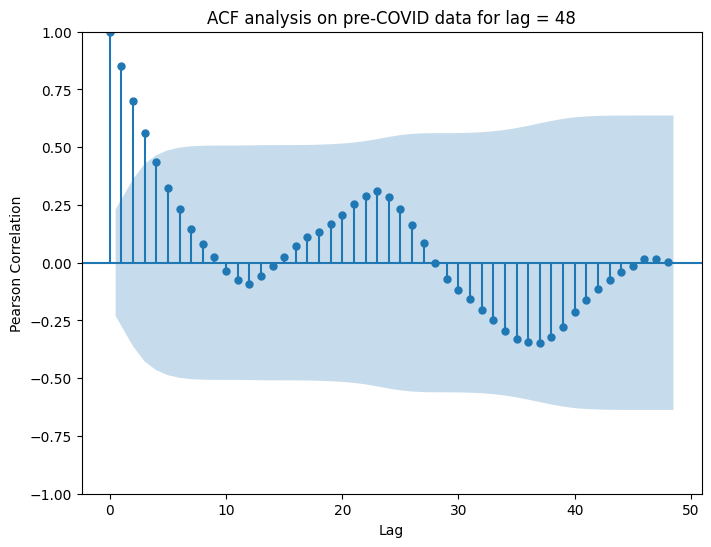

In [1170]:
# ACF for pre-COVID data
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
plot_acf(series_pre, lags=48, ax=ax)
ax.set_title(f'ACF analysis on pre-COVID data for lag = 48')
ax.set_xlabel('Lag')
ax.set_ylabel('Pearson Correlation')
plt.show()

#### **Interpretaion of ACF analysis on pre-COVID regime**
An ACF plot of the pre-COVID regime dataset corroborates our findings from the STL analysis - i.e., while seasonality is present, its overall strength on the dataset is low - as evidenced from majority of the correlation peaks (vertical bars) falling within the confidence band (shaded region).

#### **ACF Analysis of post-COVID regime:**

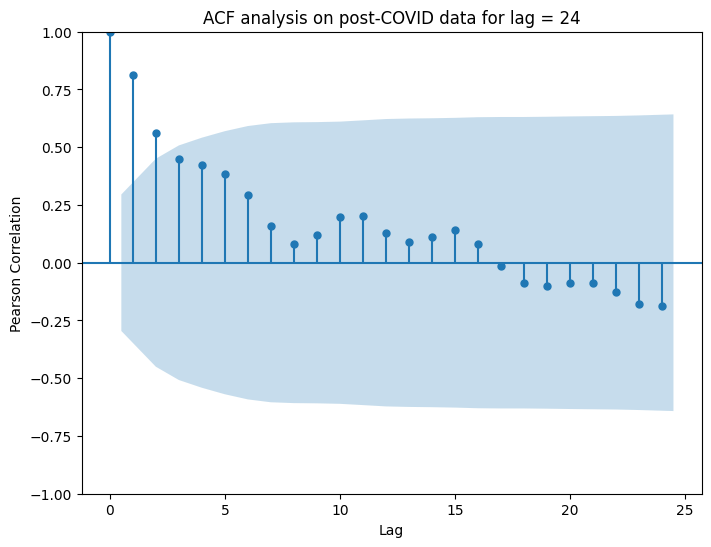

In [1171]:
# ACF for post-COVID data
fig_post, ax_post = plt.subplots(figsize=(8, 6), dpi=100)
plot_acf(series_post, lags=24, ax=ax_post)
ax_post.set_title('ACF analysis on post-COVID data for lag = 24')
ax_post.set_xlabel('Lag')
ax_post.set_ylabel('Pearson Correlation')
plt.show()

#### **Interpretaion of ACF analysis on post-COVID regime**
Contrary to our STL analysis results (which presented a moderate seasonality strength on the post-COVID regime), our ACF analysis shows only a short-term autocorrelation (lags 0 to 6) and no seasonal spikes beyond the confidence band - thereby, indicating a low (rather than moderate) seasonality strength.

#### **Joint Interpretation of STL and ACF analysis on pre and post-COVID regimes:**

1. **pre-COVID:**
    
    A joint interpretation of STL and ACF analysis on the pre-COVID regime indicates low presence of seasonality in the dataset. The subsequent CH test will conclusively determine the presence of a seasonal unit root - thereby allowing us to identify whether seasonal differencing (e.g., SARIMA) is required for forecasting in this regime.

2. **post-COVID:**

    Contrary to pre-COVID, STL and ACF analysis on the post-COVID regime has presented slightly contradicting results (with STL suggesting a moderate seasonality strength - countered by the ACF results). The subsequent CH test will conclusively determine the presence of a seasonal unit root - thereby allowing us to identify whether seasonal differencing (e.g., SARIMA) is required for forecasting in this regime.

**Key Point of Note:** While STL presented low seasonality strength on pre-COVID and moderate strength on post-COVID regimes, a collective look at the ACF plots suggests slightly higher spikes (albeit still within the confidence band) in the case of pre-COVID regime - compared to post-COVID regime - thereby, conclusively establishing the need to perform the CH test to determine the final way-forward.

### **3.3. Final Seasonality Test - CH test**
This section uses the Canova-Hansen (CH) test to conclusively determine the presence of a seasonal unit root in both pre and post-COVID regimes. Based on the outcomes of this test, we will conclusively determine whether either, or both, regimes warrant seasonal differencing during forecasting - thereby allowing us to choose between ARIMA and SARIMA models.

#### **About CH:**
#### CH: Canova-Hansen Test
The **Canova–Hansen (CH)** test checks whether a time series contains a seasonal unit root—that is, whether a seasonal difference (e.g. a 12-month difference for monthly data) is needed to make the series stationary.

**Null ($H_0$) and Alternate ($H_1$) Hypothesis in CH Test**
- Null ($H_0$) Hypothesis: the series has a seasonal unit root $\rightarrow$ seasonal differencing needed - select SARIMA.
- Alternate ($H_1$) Hypothesis: the series does not contain a seasonal unit root $\rightarrow$ seasonal differencing not needed - proceed with ARIMA.

**Definition of Seasonal Root**

Presence of a seasonal unit root in a series means that seasonality in the dataset does not follow a repeating (osciallting) pattern. E.g., A monthly series whose January values have a mean that drifts over time rather than repeating around a constant seasonal mean.

**Practical Interpretation of Seasonal Root**

Presence of a seasonal unit root means that the data must be differenced at the seasonal lag to remove the stochastic seasonal component. After removing the seasonal component, the remaining series should be stationary and suitable for forecast modelling.

**How CH Test works**

In simple terms, a CH test performs a discrete Fourier Transform on seasonal regressons (sine, cosine pairs built on only the stochastic part of the dataset) called **Periodogram Ordinates** and takes a variance-weighted sum of these ordinates to determine the **Test Statistic**. The test statistic is then compared to critical values ($p_value$ < 0.05 or $p_value$ > 0.05) to determine the final decision on whether to accept or reject the **null hypothesis**.

#### **CH Test on pre-COVID regime:**

In [1172]:
# CH Test on pre-COVID data
# Prep data
x_pre = series_pre.astype(float).to_numpy()

# Perfom test
ch_pre = CHTest(m=12)
D_pre = ch_pre.estimate_seasonal_differencing_term(x_pre)

# Print test result and decision
if D_pre > 1:
    print(f"""\nEstimated D for pre-COVID regime: {D_pre} 
          | Seasonal differencing needed --> 
          Select SARIMA for forecasting.""")
else:
    print(f"""\nEstimated D for pre-COVID regime: {D_pre} 
          | Seasonal differencing not needed --> 
          Proceed with ARIMA for forecasting.""")


Estimated D for pre-COVID regime: 0 
          | Seasonal differencing not needed --> 
          Proceed with ARIMA for forecasting.


#### **CH Test on post-COVID regime:**

In [1173]:
# CH Test on post-COVID data
# Prep data
x_post = series_post.astype(float).to_numpy()

# Perform test
ch_post = CHTest(m=12)
D_post = ch_post.estimate_seasonal_differencing_term(x_post)

# Print test result and decision
if D_post > 1:
    print(f"""\nEstimated D for post-COVID regime: {D_post:.4f} 
          | Seasonal differencing needed --> 
          Select SARIMA for forecasting.""")
else:
    print(f"""\nEstimated D for post-COVID regime: {D_post:.4f} 
          | Seasonal differencing not needed --> 
          Proceed with ARIMA for forecasting.""")


Estimated D for post-COVID regime: 0.0000 
          | Seasonal differencing not needed --> 
          Proceed with ARIMA for forecasting.


#### **Interpretation of CH Test on pre and post-COVID regimes:**
As evident from the outputs of the CH test (conducted per pmdarima) on both pre and post-COVID regimes, no seasonal roots were detected in either regimes. Hence, ARIMA model shall be the way-forward for forecasting the following scenarios:
1. **Scenario A:** Forecasting 10-year inflation rates based on pre-COVID regime (model = ARIMA)
2. **Scenario B:** Forecasting 10-year inflation rates based on post-COVID regime (model = ARIMA)

## **Section 4: 10-year Forecast**
To recap, our inflation dataset was divided into two regimes:
1. Pre-COVID - showcasing the inflation during the preiod: Jan-2014 till Dec-2019.
2. Post-COVID - showcasing the inflation during the period: Jan-2022 till Aug-2025.

Our original dataset was segregated into the above regimes due to the lack of credible data during the COVID period (2020-21).

On each dataset we performed separate seasonality tests to determine whether seasonal differencing is needed or not and STL, ACF and finally CH Test were used to determine seasonal differencing. From our seasonality tests we have come to the conclusion that seasonal differencing on the data is not needed for forecasting and hence, our choice for forecasting inflation is **ARIMA (AutoRegressive Integrated Moving Average)**.

#### **About ARIMA:**

ARIMA is a time-series forecasting model. A model is called a time-series model when it satisfies the following three conditions:

- The model explicitly depends on time ordering - i.e., the model uses past values to predict future outcomes.
- The model captures temporal dependence - i.e., patterns such as persistence, autocorrelation and seasonality are central to how the model learns.
- The model forecasts future values by extrapolating time-based relationships.

ARIMA does not directly forecast the level of a variable. It first makes the data stationary (i.e., stabilizes the mean and variance of the data) by differencing the value in the current period from the value in the past period (e.g. if inflation in Jan-15 is 4.5% and inflation in Dec-14 is 4.2%, ARIMA will first capture the rate of change for the period (a.k.a discrete differencing) i.e. 0.3%. This is done by the "Integrated (I)" component of the model). Making the data stationary essentially removes the trend from the data and the reason why this is done is because the math behind AutoRegressive (AR) and Moving Average (MA) components assume that the data they are applied on is stationary. If not, AR and MA will generate error-prone results. Once the data has been made stationary, the AR and MA components apply the linear stochastic equation ("stochastic" since the error and intercept parameters are random variables determined using Maximum Likelihood Estimation) to forecast the change (not the actual inflation value but only the change). The forecasted change is then added to the last known value of inflation to determine the predicted inflation values (thereby incorporating the trend that was originally removed during the integrated stage).

**Additional Note:** In the above explanation of the ARIMA model we subtracted Dec-14 from Jan-15 to get the rate of change. Had our data demonstrated a seasonal root, and we would have used the SARIMA model - instead of ARIMA, this differencing would be Jan-14 from Jan-15 - to account for seasonality in the data. Thus, the fundamental difference between ARIMA and SARIMA is how seasonality is accounted for. Where in ARIMA the differencing is month-on-month (i.e., $Y_t - Y_{t-1}$), in SARIMA the differencing is done on a year-on-year basis (i.e., $Y_t - Y_{t-12}$).

The ARIMA model comprises of three components:

1. **AR (AutoRegressive):** This component of the model uses linear stochastic regression to model the predicted value as a linear combination of its past values. This component is determined using **p** in the ARIMA model input.
    - **Equation:**
        $$
        Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \dots + \phi_p Y_{t-p} + \varepsilon_t
        $$
        where:
        
        $Y_t$ = current value (e.g., inflation at time t)
        
        $c$ = constant (intercept) - determined using MLE (Maximum Likelihood Estimation)
        
        $\phi_i$ = autoregressive coefficient - determined using MLE.
        
        $\varepsilon_t$ = white noise (random error)

2. **I (Integrated):** This component of the model stabilizes the mean and variance of the differences - thereby making the data stationary for AR and MA components to be applied for forecasting. This component is determined using **d** in the ARIMA model input.
    - **Equation:**
        
        If d = 1 - used when the data demonstrates a linear trend
        $$
        \nabla Y_t = Y_t - Y_{t-1}
        $$
        where:
        
        $Y_t$ = current value (e.g., inflation at time t)
        
        $Y_{t-1}$ = previous month value (e.g., inflation at time t-1)
        
        If d = 2 - used when the data demonstrates a quadratic (or exponential-like) trend
        $$
        \nabla^2 Y_t = (Y_t - Y_{t-1}) - (Y_{t-1} - Y_{t-2}) = Y_t - 2Y_{t-1} + Y_{t-2}
        $$
        where:
        
        $Y_t$ = current value (e.g., inflation at time t)
        
        $Y_{t-1}$ = previous month value (e.g., inflation at time t-1)

3. **MA (Moving Average):** This component of the model also uses linear stochastic regression but for modelling the error of the predicted value as a linear combination of its past errors. This component is determined using **q** in the ARIMA model input.
    - **Equation:**
        $$
        Y_t = c + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \dots + \theta_q \varepsilon_{t-q}
        $$
        where:
        
        $\varepsilon_t$ = white noise error - residual term - results from $c$ and  $\theta_i$
        
        $c$ = constant (intercept) - determined using MLE

        $\theta_i$ = Moving average coefficients (capturing impact of past shocks) - determined using MLE


**How it all comes together:** 

All three components explained above come together to make up the final ARIMA(p=1, d=1, q=1) equation given as follows:

$$
\nabla Y_t = c + \phi_1 (\nabla Y_{t-1}) + \varepsilon_t + \theta_1 \varepsilon_{t-1}
$$

where:

$c$ = constant (intercept) - determined using MLE

$\varepsilon_t$ = white noise error - residual term - results from $c$, $\theta_i$ and $\phi_i$

$\theta_i$ = Moving average coefficients (capturing impact of past shocks) - determined using MLE

$\phi_i$ = autoregressive coefficient - determined using MLE.


### **4.1. 10-year Forecast: Pre-COVID Regime**
Having established the mechanisms behind an ARIMA model, this section focuses on performing a 10-year forecast on the pre-COVID regime based on the same.

Summary Results:
                               SARIMAX Results                                
Dep. Variable:        Inflation_rates   No. Observations:                   72
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -68.604
Date:                Wed, 15 Oct 2025   AIC                            145.208
Time:                        00:23:32   BIC                            154.315
Sample:                    01-01-2014   HQIC                           148.834
                         - 12-01-2019                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4159      1.419      3.817      0.000       2.635       8.197
ar.L1          0.9036      0.073     12.340      0.000       0.760       1.047
ma.L1          0.4139      0.124   

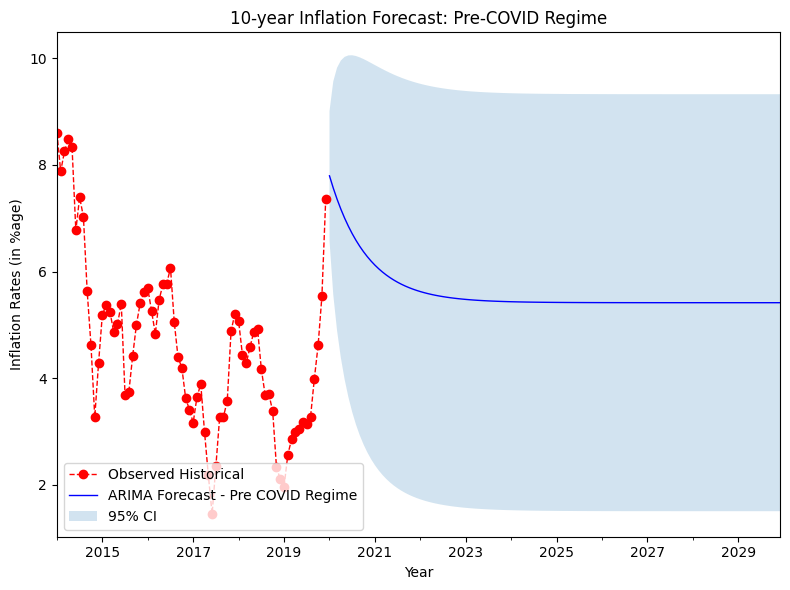

In [1174]:
# Fit ARIMA Model
model_pre = ARIMA(series_pre, order= (1, 0, 1), trend='c')
result_pre = model_pre.fit(cov_type='robust') #'robust' due to heteroskedacity
print(f'Summary Results:\n{result_pre.summary()}')
is_stationary = np.all(np.abs(result_pre.arroots) > 1)
is_invertible = np.all(np.abs(result_pre.maroots) > 1)
print(f'Stability Result:\n{is_stationary}')
print(f'Invertability Result:\n{is_invertible}')

# 10-year Forecast (12 months per year hence steps = 120)
forecast_pre = result_pre.get_forecast(steps=120)
forecast_df_pre = forecast_pre.summary_frame(alpha=0.05)
print(f'ARIMA Forecast Data:\n{forecast_df_pre['mean']}')
forecast_df_pre['mean'].to_csv(forecast_pre_dataset)

# Plot Forecast
fig_forecast_pre, ax_forecast_pre = plt.subplots(figsize=(8, 6), dpi=100)
series_pre.plot(ax=ax_forecast_pre, label='Observed Historical', 
                lw=1, color='red', 
                linestyle='--', marker='o')
forecast_df_pre['mean'].plot(ax=ax_forecast_pre, 
                             label='ARIMA Forecast - Pre COVID Regime', 
                             lw=1, 
                             color='blue')
ax_forecast_pre.fill_between(forecast_df_pre.index, 
                             forecast_df_pre['mean_ci_lower'], 
                             forecast_df_pre['mean_ci_upper'], 
                             alpha=0.2, 
                             label='95% CI')
ax_forecast_pre.set_xlabel('Year')
ax_forecast_pre.set_ylabel('Inflation Rates (in %age)')
ax_forecast_pre.set_title('10-year Inflation Forecast: Pre-COVID Regime')
ax_forecast_pre.legend()
plt.tight_layout()
plt.show()

**CONCLUSION**

To generate a forecast with minimal variance, the following iterations of the ARIMA model were analyzed:
1. **$p=2, d=1, q=1$:** log-likelihood = -67 (highest), but MLE failed to converge. Despite AIC=144, BIC=155, we exclude this model due to non-convergence/identification issues in MLE.
2. **$p=1, d=1, q=1$:** log-likelihood = -68, AIC = 143 (lowest), BIC = 152 (lowest). No reported MLE convergence issues. Variance between observed and forecasted values = 52%.
3. **$p=1, d=0, q=1$:** log-likelihood = -68, AIC = 145 and BIC = 154 (slightly worse than (1,1,1)). No reported MLE convergence issues. **Variance between observed and forecasted values is lowest = 18%**.

**Decision:** We choose ARIMA(1,0,1) because:
- it converges and has clean diagnostics, and 
- it delivers superior out-of-sample forecast accuracy, even though its AIC/BIC are marginally worse.

**Key Note:** In our selected model we set $d = 0$ because the level series appears stationary (no evidence of a unit root) and does not require trend differencing. In practice, $d$ is selected using unit-root and stationarity tests—e.g., Augmented Dickey–Fuller (ADF) or Phillips–Perron (PP) with the null of a unit root, and the KPSS test (level or trend) with the null of stationarity. Formal testing and reporting of these statistics are outside the scope of this paper; however, our visual diagnostics (ACF behavior, stability of mean/variance) are consistent with $d = 0$.

### **4.2. 10-year Forecast: Post-COVID Regime**
Building on the foundations laid in the previous sections of this paper, this section focuses on performing a 10-year forecast on the post-COVID regime dataset.

Summary Results:
                               SARIMAX Results                                
Dep. Variable:        Inflation_rates   No. Observations:                   44
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -50.840
Date:                Wed, 15 Oct 2025   AIC                            109.680
Time:                        00:23:32   BIC                            116.816
Sample:                    01-01-2022   HQIC                           112.326
                         - 08-01-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0232      0.118      0.198      0.843      -0.207       0.254
ar.L1          0.9729      0.022     45.052      0.000       0.931       1.015
ma.L1          0.5016      0.188   

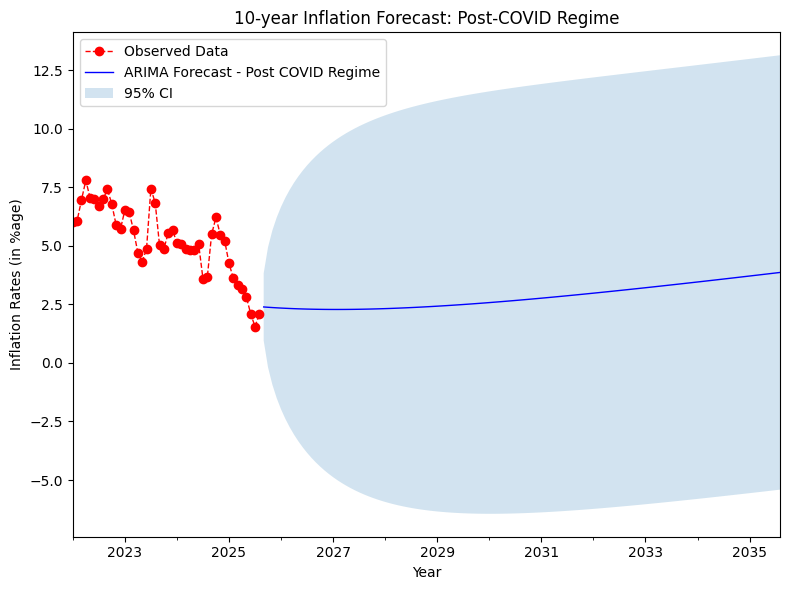

In [1175]:
# Fit ARIMA model
model_post = ARIMA(series_post, order=(1, 0, 1), trend='t')
result_post = model_post.fit(cov_type='robust')
print(f'Summary Results:\n{result_post.summary()}')
is_stationary = np.all((np.abs(result_post.arroots)) > 1)
is_invertible = np.all((np.abs(result_post.maroots)) > 1)

# 10-year Forecast (12 months per year hence steps = 120)
forecast_post = result_post.get_forecast(steps=120)
forecast_df_post = forecast_post.summary_frame(alpha=0.05)
print(f'ARIMA Forecast Data:\n{forecast_df_post['mean']}')
forecast_df_post['mean'].to_csv(forecast_post_dataset)

# Plot forecast
fig_forecast_post, ax_forecast_post = plt.subplots(figsize=(8, 6), dpi=100)
series_post.plot(ax=ax_forecast_post, label='Observed Data', 
                 lw=1, color='red', 
                 linestyle='--', 
                 marker='o')
forecast_df_post['mean'].plot(ax=ax_forecast_post, 
                              label='ARIMA Forecast - Post COVID Regime', 
                              lw=1, 
                              color='blue')
ax_forecast_post.fill_between(forecast_df_post.index, 
                              forecast_df_post['mean_ci_lower'], 
                              forecast_df_post['mean_ci_upper'], 
                              alpha=0.2, 
                              label='95% CI')
ax_forecast_post.set_xlabel('Year')
ax_forecast_post.set_ylabel('Inflation Rates (in %age)')
ax_forecast_post.set_title('10-year Inflation Forecast: Post-COVID Regime')
ax_forecast_post.legend()
plt.tight_layout()
plt.show()


**CONCLUSION**

For the post-COVID regime forecast, we have leveraged the (1, 0, 1) iteration (finalized during the pre-COVID forecasting stage) and below are the results:
1. **$p=1, d=0, q=1$:** log-likelihood = -50 (higher than pre-COVID forecast), AIC = 110 and BIC = 117 (lower than pre-COVID forecast). No reported MLE convergence issues.

**KEY POINT OF NOTE:** Although the time-trend coefficient is not statistically significant in-sample, the linear-trend specification reduced AIC/BIC and improved 12-month holdout MAE/RMSE versus an intercept-only model; we therefore retain it for forecasting. Additionally, an intercept-only model produced negative long-horizon values; the linear-trend specification avoided this and also improved holdout error. A transformation-based approach (e.g., Box-Cox/log-offset) will be explored in a follow-up.

**Decision:**
Based on the statistical results of the pre and post-COVID regimes, post-COVID regime significantly outperforms its pre-COVID counterpart. However, our forecasting approach would be to take an average of the pre and post-COVID forecast results. This approach stems from the following facts:
- The pre-COVID regime results were compared with actual observed values (not available for the post-COVID regime forecast) to capture variance.
- The pre-COVID regime results would capture behavior not seen in the post-COVID dataset - due to lesser number of observations (72 vs 44).

# **End of Document**